# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data 


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [73]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [74]:
data = pd.read_csv('train.csv')

In [75]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [76]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [77]:
print("Количество пропусков в train")
print(train.isnull().sum())
print("Количество пропусков в test")
print(test.isnull().sum())


train.fillna('', inplace=True)
test.fillna('', inplace=True)

print("Количество пропусков в train")
print(train.isnull().sum())
print("Количество пропусков в test")
print(test.isnull().sum())

Количество пропусков в train
id             0
keyword       44
location    1760
text           0
target         0
dtype: int64
Количество пропусков в test
id            0
keyword      17
location    773
text          0
target        0
dtype: int64
Количество пропусков в train
id          0
keyword     0
location    0
text        0
target      0
dtype: int64
Количество пропусков в test
id          0
keyword     0
location    0
text        0
target      0
dtype: int64


## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


In [78]:
class_counts = data['target'].value_counts()

print('Распределение классов в обучающей выборке:')
print(class_counts)

Распределение классов в обучающей выборке:
0    4342
1    3271
Name: target, dtype: int64


2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

Index(['damage', 'siren', 'wreckage', 'fatalities', 'deluge', 'twister',
       'fatality', 'harm', 'emergency', 'nuclear%20reactor'],
      dtype='object')


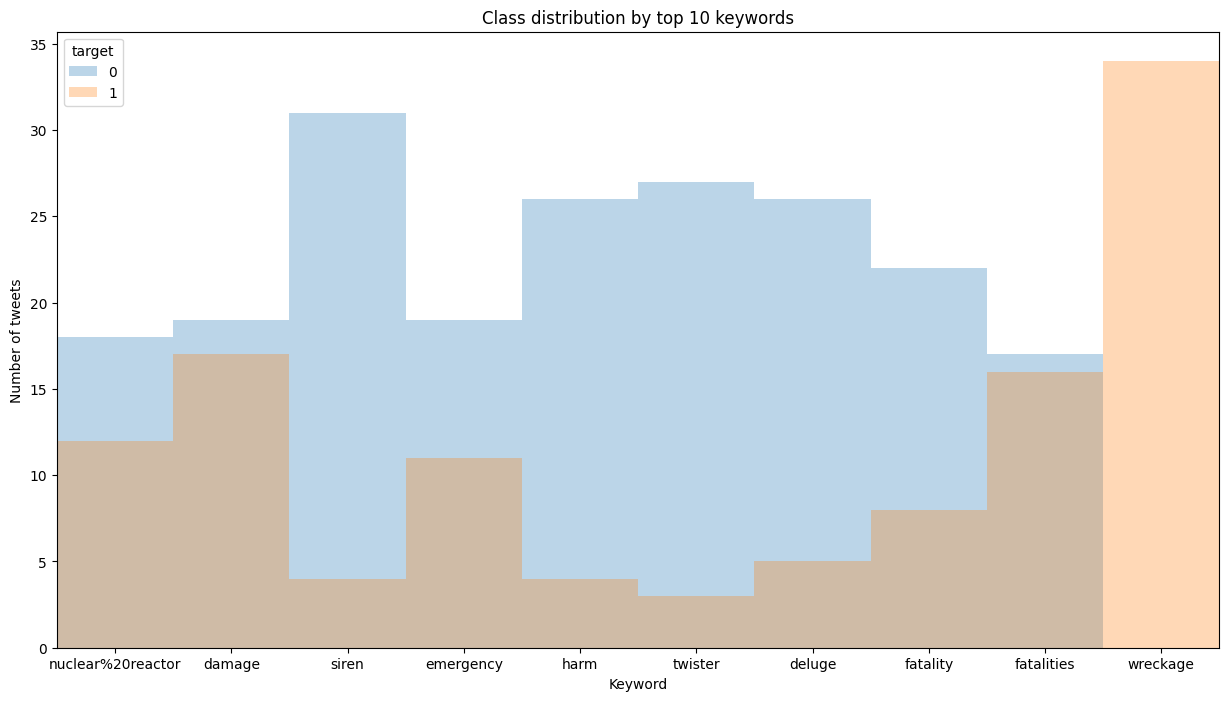

In [94]:
top_keywords = train.copy()
# чтобы пустое слово не вошло в топ по популярности
top_keywords = train[train['keyword'] != ""] 
top_keywords = top_keywords.keyword.value_counts()[:10].index
print(top_keywords)
plt.figure(figsize=(15, 8))
sns.countplot(data=train[train['keyword'].isin(top_keywords)], x='keyword', hue='target',
              alpha=0.3, saturation=1, dodge=False, width=1)
plt.xlabel('Keyword')
plt.ylabel('Number of tweets')
plt.title('Class distribution by top 10 keywords')
plt.show()

**Выводы**: По графику ыидно, что если в тивте встретилось слово "wrekage", то это в сто процентах случаев означало, что твит содержал информации о катастрофе. Твиты со словами "siren", "twister", "harm", "deluge", "fatality" чаще всего наоборот не содержат информации о катастрофе. Интересно, что уже слово "fatalities" может означать как и содержание катастрофы так и остутствие информации о ней (шанс почти 50 на 50), в то время как для слова "fatality" вероятность target = 1 намного меньше. 

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [95]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [96]:
train_new = train.copy() 
train_new['text'] = train[['keyword', 'location', 'text']].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
train_new = train_new.drop(columns=['id','keyword', 'location'])
train_new = pd.DataFrame(data = train_new)

test_new = test.copy() 
test_new['text'] = test[['keyword', 'location', 'text']].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
test_new = test_new.drop(columns=['id','keyword', 'location'])
test_new = pd.DataFrame(data = test_new)

In [97]:
train_new.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rot...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [98]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(train_new['text'])
print(X.shape)

(5329, 18455)


## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [99]:
import re

In [100]:
def contains_digit(s: str) -> bool:
    # Проверка, содержит ли слово цифры
    return bool(re.search(r'\d', s))

def contains_punctuation(s: str) -> bool:
    # Проверка, содержит ли слово пунктуацию
    return any(punctuation_char in s for punctuation_char in punctuation)

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s.startswith('#')

def is_mention(s: str) -> bool:
    # Проверка, является ли слово упоминанием
    return s.startswith('@')

def investigate_vocabulary(vocabulary):
    with_digit = [word for word in vocabulary if contains_digit(word)]
    with_punct = [word for word in vocabulary if contains_punctuation(word)]
    hashtags = [word for word in vocabulary if is_hashtag(word)]
    mentions = [word for word in vocabulary if is_mention(word)]

    print('With digit:      ', len(with_digit))
    print('With punctuation:', len(with_punct))
    print('Hashtags:        ', len(hashtags))
    print('Mentions:        ', len(mentions))

In [101]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [102]:
investigate_vocabulary(vectorizer.vocabulary_)

With digit:       3812
With punctuation: 315
Hashtags:         0
Mentions:         0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [103]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer

In [104]:
vectorizer = CountVectorizer(tokenizer=TweetTokenizer().tokenize)
train_new_vec = vectorizer.fit_transform(train_new['text'])
train_new_vec = pd.DataFrame(data = train_new_vec)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [105]:
investigate_vocabulary(vectorizer.vocabulary_)

With digit:       3939
With punctuation: 7338
Hashtags:         1470
Mentions:         1679


**Сравнение:** Очевидно, что TweetTokenizer намного лучше справился с задачей по нахождению ключевых слов (смайликов, хештэгов и тд). По сравнению с TweetTokenizer CountVectorizer работает крайне плохо, не находя вообще хэштеги и упоминания

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [106]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.snowball import SnowballStemmer

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [107]:
def contains_only_latin_letters(s: str) -> bool:
    # Проверка, содержит ли слово только латинские буквы
    return all(c.isalpha() and c.isascii() for c in s)

def is_emoji(s: str) -> bool:
    # Проверка, является ли слово смайликом
    return bool(re.match(r'^[:;8xX=]-?[)D\]\(\]/\\OpP]$', s))

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s.startswith('#') and all(c.isalpha() for c in s[1:])

def custom_tokenizer(s: str) -> List[str]:    
    # Кастомный токенайзер
    stemmer = SnowballStemmer('english')
    tknzr = TweetTokenizer()
    stop_words = stopwords.words('english')
    
    tokens = tknzr.tokenize(s.lower())
    tokens = [t for t in tokens if contains_only_latin_letters(t) or is_emoji(t) or is_hashtag(t)]
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [stemmer.stem(t) for t in tokens]
    
    return tokens

In [108]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [110]:
for text in train_new['text'].tolist()[:10]:
    print(custom_tokenizer(text))

['bridg', 'ash', 'australia', 'collaps', 'trent', 'bridg', 'among', 'worst', 'histori', 'england', 'bundl', 'australia']
['hail', 'carol', 'stream', 'illinoi', 'great', 'michigan', 'techniqu', 'camp', 'thank', '#goblu', '#wrestleon']
['polic', 'houston', 'cnn', 'tennesse', 'movi', 'theater', 'shoot', 'suspect', 'kill', 'polic']
['riot', 'still', 'riot', 'coupl', 'hour', 'left', 'class']
['wound', 'lake', 'highland', 'crack', 'path', 'wipe', 'morn', 'beach', 'run', 'surfac', 'wound', 'left', 'elbow', 'right', 'knee']
['airplan', 'somewher', 'expert', 'franc', 'begin', 'examin', 'airplan', 'debri', 'found', 'reunion', 'island', 'french', 'air', 'accid', 'expert', '#mlb']
['bloodi', 'isol', 'citi', 'world', 'perth', 'came', 'kill', 'indian', 'fun', 'video', 'smirk', 'remorseless', 'pakistani', 'killer', 'show', 'boast']
['burn', 'except', 'idk', 'realli', 'burn']
['destroy', 'ask', 'destroy', 'hous']
['wound', 'maracay', 'nirgua', 'venezuela', 'polic', 'offic', 'wound', 'suspect', 'dead',

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [111]:
vectorizer  = CountVectorizer(tokenizer=custom_tokenizer)

train_copy = train_new.copy()
test_copy = test_new.copy()

y_train = train_new['target']
y_test = test_new['target']

train_copy.drop(columns=['target'])
test_copy.drop(columns=['target'])

X_train = vectorizer.fit_transform(train_copy['text'])
X_test = vectorizer .transform(test_copy['text'])


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


2. Обучите LogisticRegression на полученных признаках.


In [112]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

3. Посчитайте метрику f1-score на тестовых данных.

In [113]:
from sklearn.metrics import f1_score

y_test_pred = lr.predict(X_test)
f1 = f1_score(y_test, y_test_pred)
print('F1 score:', f1)

F1 score: 0.752283718430951


## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [114]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer  = TfidfVectorizer(tokenizer=custom_tokenizer)

train_copy = train_new.copy()
test_copy = test_new.copy()

y_train = train_new['target']
y_test = test['target']

train_copy.drop(columns=['target'])
test_copy.drop(columns=['target'])

X_train = vectorizer.fit_transform(train_copy['text'])
X_test = vectorizer.transform(test_copy['text'])

lr = LogisticRegression()
lr.fit(X_train, y_train)

y_test_pred = lr.predict(X_test)
f1 = f1_score(y_test, y_test_pred)
print('F1 score:', f1)
print(f"Размер матрицы: {X_train.shape}")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.7433333333333335
Размер матрицы: (5329, 10488)



1. **Ответ:** с tf-idf векторизатором стало немного хуже. В целом качестов не сильно изменилось

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [115]:
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9)

train_copy = train_new.copy()
test_copy = test_new.copy()

y_train = train_new['target']
y_test = test['target']

train_copy.drop(columns=['target'])
test_copy.drop(columns=['target'])

X_train = vectorizer.fit_transform(train_copy['text'])
X_test = vectorizer.transform(test_copy['text'])

lr = LogisticRegression()
lr.fit(X_train, y_train)

y_test_pred = lr.predict(X_test)
f1 = f1_score(y_test, y_test_pred)
print('F1 score:', f1)
print(f"Размер матрицы: {X_train.shape}")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.7433333333333335
Размер матрицы: (5329, 10488)


2. **Ответ:** Ни качество, ни размер матрицы не изменились

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [116]:
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, min_df=0.001, max_df=0.9)

train_copy = train_new.copy()
test_copy = test_new.copy()

y_train = train_new['target']
y_test = test['target']

train_copy.drop(columns=['target'])
test_copy.drop(columns=['target'])

X_train = vectorizer.fit_transform(train_copy['text'])
X_test = vectorizer.transform(test_copy['text'])

lr = LogisticRegression()
lr.fit(X_train, y_train)

y_test_pred = lr.predict(X_test)
f1 = f1_score(y_test, y_test_pred)
print('F1 score:', f1)
print(f"Размер матрицы: {X_train.shape}")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.7449259462424574
Размер матрицы: (5329, 1741)


3. **Ответ:** Рамзер матрицы сильно уменшился, но это совсем чуть-чуть улучшило качество.

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [117]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer  = HashingVectorizer(tokenizer=custom_tokenizer, n_features=5000)

train_copy = train_new.copy()
test_copy = test_new.copy()

y_train = train_new['target']
y_test = test['target']

train_copy.drop(columns=['target'])
test_copy.drop(columns=['target'])

X_train = vectorizer.fit_transform(train_copy['text'])
X_test = vectorizer.transform(test_copy['text'])

lr = LogisticRegression()
lr.fit(X_train, y_train)

y_test_pred = lr.predict(X_test)
f1 = f1_score(y_test, y_test_pred)
print('F1 score:', f1)
print(f"Размер матрицы: {X_train.shape}")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.7216954824316787
Размер матрицы: (5329, 5000)


2. Какой из подходов показал самый высокий результат?

2. **Ответ:** Смотря на полученные результаты, очевидно, что первый вариант (CountVectorizer(tokenizer=custom_tokenizer)) дал самое высокое качество

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [118]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer)

train_copy = train_new.copy()
test_copy = test_new.copy()

y_train = train_new['target']
y_test = test['target']

train_copy.drop(columns=['target'])
test_copy.drop(columns=['target'])

X_train = vectorizer.fit_transform(train_copy['text'])
X_test = vectorizer.transform(test_copy['text'])

lr = LogisticRegression()
lr.fit(X_train, y_train)

y_test_pred = lr.predict(X_test)
f1 = f1_score(y_test, y_test_pred)
print('F1 score:', f1)
print(f"Размер матрицы: {X_train.shape}")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.752283718430951
Размер матрицы: (5329, 10488)
